# Prophet Model - 3

---

#### Imports

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prophet specific imports
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot_forecast_component

from forecast_tools.metrics import winkler_score

import ts_utils

# Suppress FutureWarnings for DatetimeProperties.to_pydatetime()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Checking version 1.0 > - uncomment the below to check
# prophet.__version__

#### Loading Data

In [2]:
# Load in the dataset and ensure frequency is set to daily
paeds_ed_appointments = pd.read_csv('paediatrics_train.csv',
                                    index_col='date',
                                    parse_dates=True)

paeds_ed_appointments.index.freq = 'D'

In [3]:
# Train-test split: Training (all but the last 28 days)
# Testing (the last 28 days)
train = paeds_ed_appointments["paed_ed_attends"].iloc[:-28]
test = paeds_ed_appointments["paed_ed_attends"].iloc[-28:]

#### Expected Prophet Formatted Data

In [4]:
yp_train = ts_utils.prophet_training_data(train)

In [5]:
yp_train.head()

,ds,y
0,2014-04-01,47
1,2014-04-02,46
2,2014-04-03,47
3,2014-04-04,48
4,2014-04-05,52


#### Making a Prediction & Generating Forecasts

I could place a `random_state=42` within my initialisation of the model if I wanted
 the Prediction Intervals (PI) to remain the same each time a model was ran however,
 Prophet uses *Monte Carlo* sampling for PI's. 
 
 It's important to note that the predictions (yhat) values will not be affected.
 [Prophet's documentation](https://facebook.github.io/prophet/docs/diagnostics.html)
 also states that you can disable the *uncertainty sampling* by setting
 `mcmc_samples=0`, but this also means that it will no longer capture uncertainty
 in the model.

#### Prophet Baseline Standard

In [6]:
# Create and fit a Baseline Prophet model (No Holidays or Seasonality)
baseline_model = Prophet(interval_width=0.80)
baseline_model.fit(yp_train)

18:21:51 - cmdstanpy - INFO - Chain [1] start processing
18:21:52 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Make a forecast for the next 28 days
future_baseline = baseline_model.make_future_dataframe(periods=28)
forecast_baseline = baseline_model.predict(future_baseline)
forecast_baseline.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1051,2017-02-15,51.230371,38.759209,57.452510,51.221979,51.239432,-3.057193,-3.057193,-3.057193,-1.726436,-1.726436,-1.726436,-1.330757,-1.330757,-1.330757,0.0,0.0,0.0,48.173178
1052,2017-02-16,51.230975,38.963703,57.485672,51.221994,51.240843,-3.239153,-3.239153,-3.239153,-1.636888,-1.636888,-1.636888,-1.602265,-1.602265,-1.602265,0.0,0.0,0.0,47.991821
1053,2017-02-17,51.231579,40.071110,58.713436,51.221804,51.241974,-2.079728,-2.079728,-2.079728,-0.283913,-0.283913,-0.283913,-1.795815,-1.795815,-1.795815,0.0,0.0,0.0,49.151851
1054,2017-02-18,51.232183,40.237574,58.410913,51.221444,51.243225,-2.093555,-2.093555,-2.093555,-0.191085,-0.191085,-0.191085,-1.902470,-1.902470,-1.902470,0.0,0.0,0.0,49.138627
1055,2017-02-19,51.232787,43.313693,60.919655,51.221303,51.244295,1.080387,1.080387,1.080387,2.995296,2.995296,2.995296,-1.914909,-1.914909,-1.914909,0.0,0.0,0.0,52.313174


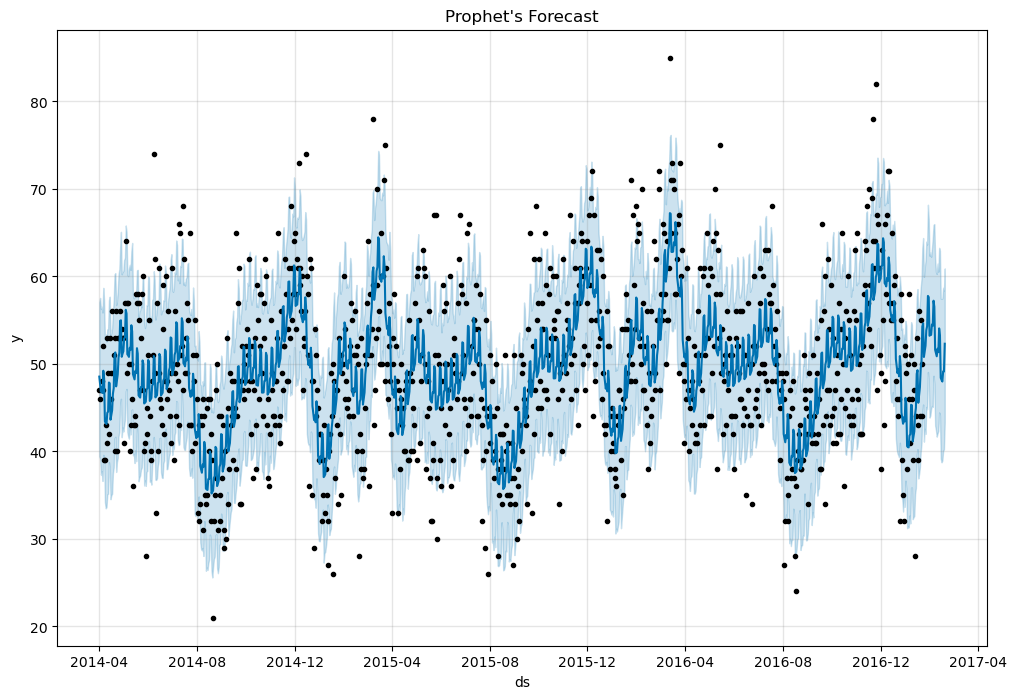

In [8]:
# Plot the forecast components
fig, ax = plt.subplots(figsize=(12, 8))

fig = baseline_model.plot(forecast_baseline, ax=ax)

ax.set_title("Prophet's Forecast")

plt.show()

#### Plotting Models Components

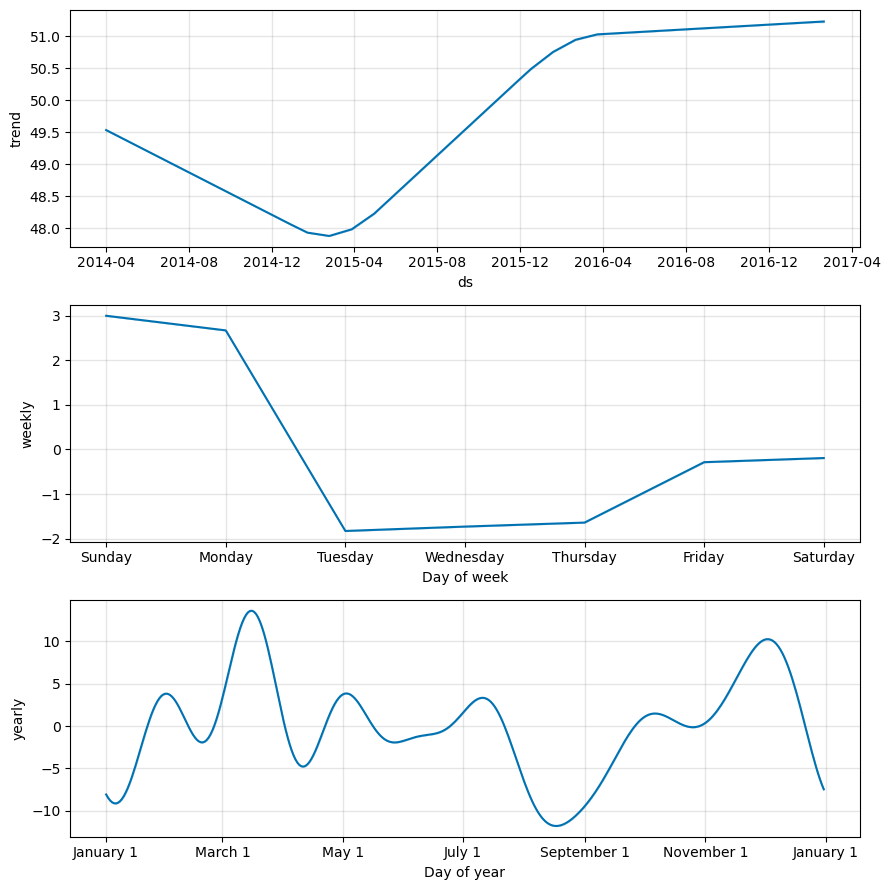

In [9]:
# Plot Prophet forecast components
baseline_model.plot_components(forecast_baseline)
plt.show()

#### Prophet Model with UK Holidays

In [10]:
# Prophet Model with UK holidays
holiday_model = Prophet(interval_width=0.80)
holiday_model.add_country_holidays(country_name='UK')
holiday_model.fit(yp_train)

18:21:55 - cmdstanpy - INFO - Chain [1] start processing
18:21:55 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
# Predict and plot again with holidays
future_holiday = holiday_model.make_future_dataframe(periods=28)
forecast_holiday = holiday_model.predict(future_holiday)

In [12]:
# What holidays are included
holiday_model.train_holiday_names.to_list()

['Good Friday',
 'May Day',
 'Spring Bank Holiday',
 "New Year's Day",
 'Christmas Day',
 'Christmas Day (observed)',
 'Boxing Day',
 "New Year's Day (observed)",
 'Boxing Day (observed)']

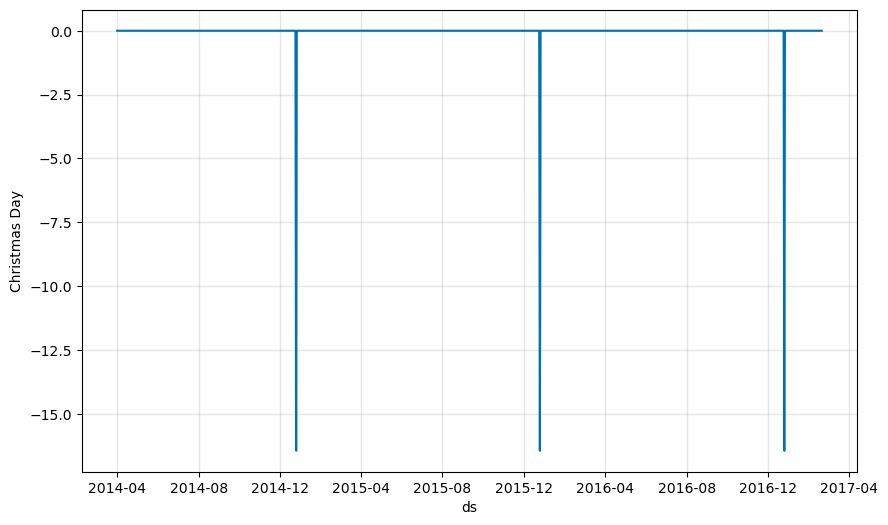

In [13]:
# Checking if Christmas Day has a substantial impact
plot_forecast_component(holiday_model, forecast_holiday, 'Christmas Day');

#### Prophet with Monthly Seasonality

In [14]:
# Add monthly seasonality and refit the model
monthly_model = Prophet(interval_width=0.80, daily_seasonality=False)
monthly_model.add_country_holidays(country_name='UK')
monthly_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
monthly_model.fit(yp_train)

# Predict and plot again with seasonality
future_monthly = monthly_model.make_future_dataframe(periods=28)
forecast_monthly = monthly_model.predict(future_monthly)

18:21:56 - cmdstanpy - INFO - Chain [1] start processing
18:21:56 - cmdstanpy - INFO - Chain [1] done processing


#### Prophet with Weekly Seasonality

In [15]:
# Add weekly seasonality and refit the model
weekly_model = Prophet(interval_width=0.80, daily_seasonality=False)
weekly_model.add_country_holidays(country_name='UK')
weekly_model.add_seasonality(name='weekly', period=7, fourier_order=3)
weekly_model.fit(yp_train)

# Predict and plot again with seasonality
future_weekly = weekly_model.make_future_dataframe(periods=28)
forecast_weekly = weekly_model.predict(future_weekly)

18:21:57 - cmdstanpy - INFO - Chain [1] start processing
18:21:57 - cmdstanpy - INFO - Chain [1] done processing


# Cross Validation

In [16]:
# Cross Validation for Baseline Prophet Model
df_cv_baseline = cross_validation(
    model=baseline_model,
    initial='366 days',
    period='28 days',
    horizon='7 days'
)

# Cross Validation for Prophet Model with Holidays
df_cv_holiday = cross_validation(
    model=holiday_model,
    initial='366 days',
    period='28 days',
    horizon='7 days'
)

# Cross Validation for Prophet Model with Monthly Seasonality
df_cv_monthly = cross_validation(
    model=monthly_model,
    initial='366 days',
    period='28 days',
    horizon='7 days'
)

# Cross Validation for Prophet Model with Weekly Seasonality
df_cv_weekly = cross_validation(
    model=weekly_model,
    initial='366 days',
    period='28 days',
    horizon='7 days'
)

  0%|          | 0/24 [00:00<?, ?it/s]

18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
18:21:58 - cmdstanpy - INFO - Chain [1] start processing
18:21:58 - cmdstanpy - INFO - Chain [1] done processing
18:21:59 - cmdstanpy - INFO - Chain [1] start processing
18:21:59 - cmdstanpy - INFO - Chain [1] done processing
18:21:59 - cmdstanpy - INFO - Chain [1] start processing
18:21:59 - cmdstanpy - INFO - Chain [1] done processing
18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
18:22:00 - cmdstanpy - INFO - Chain [1] start processing
18:22:00 - cmdstanpy - INFO - Chain [1] done processing
18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:01 - cmdstanpy - INFO - Chain [1] done processing
18:22:01 - cmdstanpy - INFO - Chain [1] start processing
18:22:01 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:10 - cmdstanpy - INFO - Chain [1] start processing
18:22:10 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:11 - cmdstanpy - INFO - Chain [1] done processing
18:22:11 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:12 - cmdstanpy - INFO - Chain [1] done processing
18:22:12 - cmdstanpy - INFO - Chain [1] start processing
18:22:13 - cmdstanpy - INFO - Chain [1] done processing
18:22:13 - cmdstanpy - INFO - Chain [1] start processing
18:22:13 - cmdstanpy - INFO - Chain [1] done processing
18:22:13 - cmdstanpy - INFO - Chain [1] start processing
18:22:14 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

18:22:22 - cmdstanpy - INFO - Chain [1] start processing
18:22:23 - cmdstanpy - INFO - Chain [1] done processing
18:22:23 - cmdstanpy - INFO - Chain [1] start processing
18:22:23 - cmdstanpy - INFO - Chain [1] done processing
18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
18:22:24 - cmdstanpy - INFO - Chain [1] start processing
18:22:24 - cmdstanpy - INFO - Chain [1] done processing
18:22:25 - cmdstanpy - INFO - Chain [1] start processing
18:22:25 - cmdstanpy - INFO - Chain [1] done processing
18:22:25 - cmdstanpy - INFO - Chain [1] start processing
18:22:26 - cmdstanpy - INFO - Chain [1] done processing
18:22:26 - cmdstanpy - INFO - Chain [1] start processing
18:22:26 - cmdstanpy - INFO - Chain [1] done processing
18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1] done processing
18:22:27 - cmdstanpy - INFO - Chain [1] start processing
18:22:27 - cmdstanpy - INFO - Chain [1]

  0%|          | 0/24 [00:00<?, ?it/s]

18:22:37 - cmdstanpy - INFO - Chain [1] start processing
18:22:37 - cmdstanpy - INFO - Chain [1] done processing
18:22:38 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing
18:22:38 - cmdstanpy - INFO - Chain [1] start processing
18:22:38 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
18:22:39 - cmdstanpy - INFO - Chain [1] start processing
18:22:39 - cmdstanpy - INFO - Chain [1] done processing
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:40 - cmdstanpy - INFO - Chain [1] start processing
18:22:40 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1] done processing
18:22:41 - cmdstanpy - INFO - Chain [1] start processing
18:22:41 - cmdstanpy - INFO - Chain [1]

In [17]:
# Rolling window = 1 means that we only get the 7 day horizon
df_p_baseline = performance_metrics(df_cv_baseline, rolling_window=1)
mae_score_baseline = df_p_baseline['mae'].mean()
print(f"CV Baseline Prophet Model MAE Score: {mae_score_baseline:.2f}")

df_p_holiday = performance_metrics(df_cv_holiday, rolling_window=1)
mae_score_holiday = df_p_holiday['mae'].mean()
print(f"CV UK Holiday Prophet Model MAE Score: {mae_score_holiday:.2f}")

df_p_monthly = performance_metrics(df_cv_monthly, rolling_window=1)
mae_score_monthly = df_p_monthly['mae'].mean()
print(f"CV Monthly Prophet Model MAE Score: {mae_score_monthly:.2f}")

df_p_weekly = performance_metrics(df_cv_weekly, rolling_window=1)
mae_score_weekly = df_p_weekly['mae'].mean()
print(f"CV Weekly Prophet Model MAE Score: {mae_score_weekly:.2f}")

CV Baseline Prophet Model MAE Score: 6.33
CV UK Holiday Prophet Model MAE Score: 6.11
CV Monthly Prophet Model MAE Score: 6.19
CV Weekly Prophet Model MAE Score: 6.13


In [18]:
df_p_holiday = performance_metrics(df_cv_holiday, rolling_window=1)
df_p_holiday

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,58.298641,7.635355,6.108206,0.125867,0.099162,0.122851,0.779762


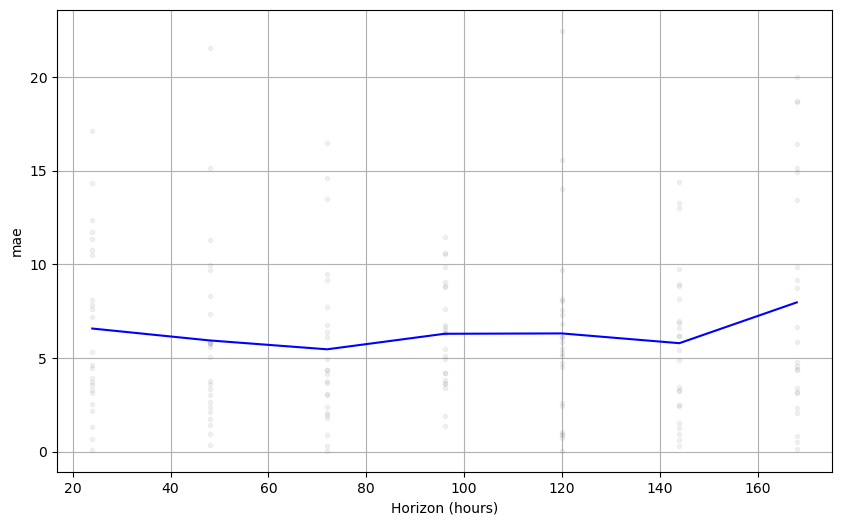

In [19]:
# Plot cross-validation metric MAE
fig = plot_cross_validation_metric(df_cv_baseline,
                                   metric='mae',
                                   rolling_window=0.1)
plt.show()

In [20]:
# Now we know that Prophet modelling with UK holidays has the lowest MAE
holiday_model_90 = Prophet(interval_width=0.90)
holiday_model_90.add_country_holidays(country_name='UK')
holiday_model_90.fit(yp_train)

18:22:50 - cmdstanpy - INFO - Chain [1] start processing
18:22:50 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Predict and plot again with holidays
future_holiday_90 = holiday_model_90.make_future_dataframe(periods=28)
forecast_holiday_90 = holiday_model_90.predict(future_holiday_90)

## Winkler Score

In [22]:
# Extract forecasted values and prediction intervals (only last 28 days)
holiday_predictions_80 = forecast_holiday[['ds',
                                           'yhat',
                                           'yhat_lower',
                                           'yhat_upper']].tail(28)


weekly_predictions_80 = forecast_weekly[['ds',
                                         'yhat',
                                         'yhat_lower',
                                         'yhat_upper']].tail(28)


monthly_predictions_80 = forecast_monthly[['ds',
                                           'yhat',
                                           'yhat_lower',
                                           'yhat_upper']].tail(28)


baseline_predictions_80 = forecast_baseline[['ds',
                                             'yhat',
                                             'yhat_lower',
                                             'yhat_upper']].tail(28)

In [23]:
# Extract forecasted values and prediction intervals (only last 28 days)
holiday_predictions_90 = forecast_holiday_90[['ds',
                                              'yhat',
                                              'yhat_lower',
                                              'yhat_upper']].tail(28)


weekly_predictions_90 = forecast_weekly[['ds',
                                         'yhat',
                                         'yhat_lower',
                                         'yhat_upper']].tail(28)


monthly_predictions_90 = forecast_monthly[['ds',
                                           'yhat',
                                           'yhat_lower',
                                           'yhat_upper']].tail(28)


baseline_predictions_90 = forecast_baseline[['ds',
                                             'yhat',
                                             'yhat_lower',
                                             'yhat_upper']].tail(28)

In [24]:
# Convert intervals to numpy arrays for Winkler scoring (28,2)
intervals_90 = np.column_stack((
    holiday_predictions_90['yhat_lower'].values,
    holiday_predictions_90['yhat_upper'].values
))

intervals_80 = np.column_stack((
    holiday_predictions_80['yhat_lower'].values,
    holiday_predictions_80['yhat_upper'].values
))

intervals_90_weekly = np.column_stack((
    weekly_predictions_90['yhat_lower'].values,
    weekly_predictions_90['yhat_upper'].values
))

intervals_80_weekly = np.column_stack((
    weekly_predictions_80['yhat_lower'].values,
    weekly_predictions_80['yhat_upper'].values
))

intervals_90_monthly = np.column_stack((
    monthly_predictions_90['yhat_lower'].values,
    monthly_predictions_90['yhat_upper'].values
))

intervals_80_monthly = np.column_stack((
    monthly_predictions_80['yhat_lower'].values,
    monthly_predictions_80['yhat_upper'].values
))

intervals_90_baseline = np.column_stack((
    baseline_predictions_90['yhat_lower'].values,
    baseline_predictions_90['yhat_upper'].values
))

intervals_80_baseline = np.column_stack((
    baseline_predictions_80['yhat_lower'].values,
    baseline_predictions_80['yhat_upper'].values
))

In [25]:
# Calculate Winkler scores
prophet_winkler_90 = winkler_score(
    intervals=intervals_90,
    observations=pd.DataFrame(test.values),
    alpha=0.1
)

prophet_winkler_80 = winkler_score(
    intervals=intervals_80,
    observations=pd.DataFrame(test.values),
    alpha=0.2
)

# Weekly Model
prophet_winkler_90_weekly = winkler_score(
    intervals=intervals_90_weekly,
    observations=pd.DataFrame(test.values),
    alpha=0.1
)

prophet_winkler_80_weekly = winkler_score(
    intervals=intervals_80_weekly,
    observations=pd.DataFrame(test.values),
    alpha=0.2
)

# Monthly Model
prophet_winkler_90_monthly = winkler_score(
    intervals=intervals_90_monthly,
    observations=pd.DataFrame(test.values),
    alpha=0.1
)

prophet_winkler_80_monthly = winkler_score(
    intervals=intervals_80_monthly,
    observations=pd.DataFrame(test.values),
    alpha=0.2
)

# Baseline Model
prophet_winkler_90_baseline = winkler_score(
    intervals=intervals_90_baseline,
    observations=pd.DataFrame(test.values),
    alpha=0.1
)

prophet_winkler_80_baseline = winkler_score(
    intervals=intervals_80_baseline,
    observations=pd.DataFrame(test.values),
    alpha=0.2
)

# Prophet with UK Holidays
print(f"Prophet (with UK Holidays) Winkler Score for 90% interval:"
      f" {prophet_winkler_90:.2f}")
print(f"Prophet (with UK Holidays) Winkler Score for 80% interval:"
      f" {prophet_winkler_80:.2f}\n")

# Prophet with Weekly Seasonality
print(f"Prophet (with weekly seasonality) Winkler Score for 90% interval:"
      f" {prophet_winkler_90_weekly:.2f}")
print(f"Prophet (with weekly seasonality) Winkler Score for 80% interval:"
      f" {prophet_winkler_80_weekly:.2f}\n")

# Prophet with Monthly Seasonality
print(f"Prophet (with monthly seasonality) Winkler Score for 90% interval:"
      f" {prophet_winkler_90_monthly:.2f}")
print(f"Prophet (with monthly seasonality) Winkler Score for 80% interval:"
      f" {prophet_winkler_80_monthly:.2f}\n")

# Prophet Baseline Model
print(f"Prophet (baseline mdodel) Winkler Score for 90% interval:"
      f" {prophet_winkler_90_baseline:.2f}")
print(f"Prophet (baseline mdodel) Winkler Score for 80% interval:"
      f" {prophet_winkler_80_baseline:.2f}\n")

Prophet (with UK Holidays) Winkler Score for 90% interval: 26.22
Prophet (with UK Holidays) Winkler Score for 80% interval: 24.35

Prophet (with weekly seasonality) Winkler Score for 90% interval: 28.94
Prophet (with weekly seasonality) Winkler Score for 80% interval: 23.71

Prophet (with monthly seasonality) Winkler Score for 90% interval: 33.33
Prophet (with monthly seasonality) Winkler Score for 80% interval: 25.71

Prophet (baseline mdodel) Winkler Score for 90% interval: 30.74
Prophet (baseline mdodel) Winkler Score for 80% interval: 24.65



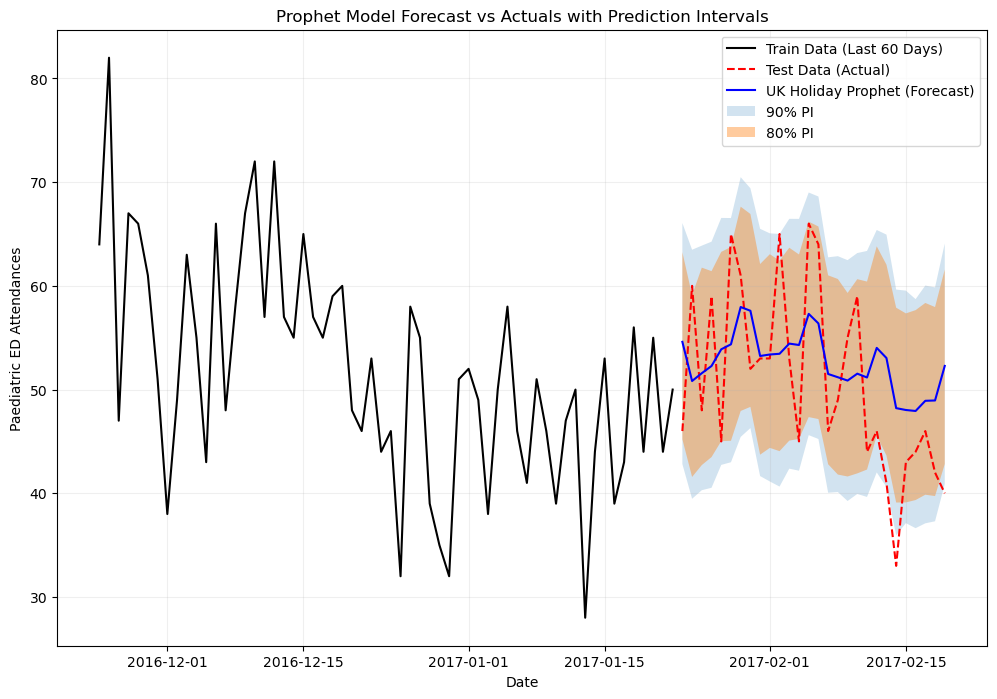

In [26]:
# Plot forecast with prediction intervals
plt.figure(figsize=(12, 8))

# Plot last 60 days of training data
plt.plot(train.index[-60:],
         train[-60:],
         label="Train Data (Last 60 Days)",
         color='black')

# Plot actual test data
plt.plot(test.index,
         test,
         label="Test Data (Actual)",
         color='red',
         linestyle='dashed')

# Plot forecasted values for the next 28 days
plt.plot(forecast_holiday['ds'][-28:],
         forecast_holiday['yhat'][-28:],
         label="UK Holiday Prophet (Forecast)",
         color='blue')

# Plot 90% prediction interval
plt.fill_between(holiday_predictions_90['ds'],
                 intervals_90[:, 0],
                 intervals_90[:, 1],
                 alpha=0.2,
                 label='90% PI')

# Plot 80% prediction interval
plt.fill_between(holiday_predictions_80['ds'],
                 intervals_80[:, 0],
                 intervals_80[:, 1],
                 alpha=0.4,
                 label='80% PI')

plt.title("Prophet Model Forecast vs Actuals with Prediction Intervals")
plt.xlabel("Date")
plt.ylabel("Paediatric ED Attendances")
plt.legend(loc="best")
plt.grid(True, alpha=0.2)

plt.show()

---

#### Save Predictions to a CSV

In [28]:
# Folder where the CSV will be saved
output_folder = "model_predictions" 

# Keep only the relevant columns from Prophet's forecast
forecast_df_prophet = holiday_predictions_80[["ds",
                                              "yhat",
                                              "yhat_lower",
                                              "yhat_upper"]].copy()

# Rename columns for clarity
forecast_df_prophet.columns = ["Date",
                               "Prophet_Forecast",
                               "Lower_80_PI",
                               "Upper_80_PI"]

# Add the 90% Prediction Intervals from holiday_predictions_90
forecast_df_prophet["Lower_90_PI"] = holiday_predictions_90["yhat_lower"].values
forecast_df_prophet["Upper_90_PI"] = holiday_predictions_90["yhat_upper"].values

# Save to CSV inside "model_predictions" folder
forecast_path_prophet = f"{output_folder}/prophet_forecast.csv"
forecast_df_prophet.to_csv(forecast_path_prophet, index=False)

print(f"Prophet forecast saved to {forecast_path_prophet}")
print(forecast_df_prophet.head())

Prophet forecast saved to model_predictions/prophet_forecast.csv
           Date  Prophet_Forecast  Lower_80_PI  Upper_80_PI  Lower_90_PI  \
1028 2017-01-23         54.601546    45.211002    63.247984    42.818504   
1029 2017-01-24         50.825969    41.573356    59.100218    39.467459   
1030 2017-01-25         51.580502    42.720445    61.757393    40.296996   
1031 2017-01-26         52.274693    43.490864    61.420728    40.530185   
1032 2017-01-27         53.883669    45.030112    63.277251    42.736356   

      Upper_90_PI  
1028    66.059486  
1029    63.484542  
1030    63.878621  
1031    64.260883  
1032    66.551083  


*Page 5*